In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Reading the data

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df = pd.concat([train, test], axis=0, sort=True)

Checking the ratio

In [ ]:
df['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

replaced some of the uncommon titles with more common ones for the sake of simplicity.


In [ ]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# replacing some titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

df['Title'].value_counts()

Mr        767
Miss      264
Mrs       201
Master     61
Dr          8
Rev         8
Name: Title, dtype: int64

Everyone can be grouped into 6 titles and using the titles we created, we can fill in missing ages using the median of all the other individuals with the same title.

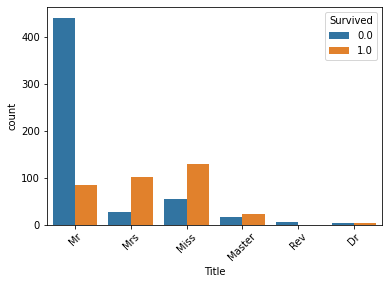

In [ ]:
#input missing age values using median of title groups

title_ages = dict(df.groupby('Title')['Age'].median())

df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

# viz of survival rates of titles

sns.countplot(x='Title', data=df, hue='Survived')
plt.xticks(rotation=45)
plt.show()

Next, I do something similar as I did with missing age values, but this time with missing fare values. I used the median fare value for each passenger class as the value for corresponding missing values.

In [ ]:
# impute missing Fare values using median of Pclass groups
class_fares = dict(df.groupby('Pclass')['Fare'].median())

# create a column of the average fares
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

There are only 2 missing values in ‘Embarked’ so just I use the method backfill to get rid of the null values. I also create a new variable in the dataset called family size, calculated using the two variables of Parch and SibSp and adding them together.


In [ ]:

df['Embarked'].fillna(method='backfill', inplace=True)

df['Family_Size'] = df['Parch'] + df['SibSp']

Spliting up data again for training & testing for making up the neural network


In [ ]:
train = df[pd.notnull(df['Survived'])]
test  = df[pd.isnull(df['Survived'])]

Importing some more libraries


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed

Droping some of the variables that wont be used.

Also scaling some continous variables to make it simpler for neural network to test

In [ ]:
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

continuous = ['Age','Fare','Parch','Pclass','SibSp','Family_Size']

scaler = StandardScaler()

for var in continuous:
     df[var] = df[var].astype('float64')
     df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))
   
df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,Family_Size
0,-0.574635,S,-0.503176,-0.445,0.841916,male,0.481288,0.0,Mr,0.073352
1,0.641140,C,0.734809,-0.445,-1.546098,female,0.481288,1.0,Mrs,0.073352
2,-0.270692,S,-0.490126,-0.445,0.841916,female,-0.479087,1.0,Miss,-0.558346
3,0.413182,S,0.383263,-0.445,-1.546098,female,0.481288,1.0,Mrs,0.073352
4,0.413182,S,-0.487709,-0.445,0.841916,male,-0.479087,0.0,Mr,-0.558346


Splitting the data into training and testing data sets

In [ ]:
X_train= df[pd.notnull(df['Survived'])].drop(['Survived'],axis=1)
y_train= df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'],axis=1)

Converting all the columns into feature columns for processing and creating the model.

We create an input function that would feed dataframe into out classified model.

Tf.estimator.inputs provide a very simple way for doing this 

 It just requires specific features, labels, and batch size. It also has a special argument called shuffle, which allows the model to read the records in a random order, thereby improving model performance.

I also defined our linear classifier. This linear classifier will train a linear model to classify things into one of the two possible classes - i.e. 0 for survival and 0 for not surviving. tf.estimator.LinearClassifier allows this to happen with just a single line of code. As a part of arguments, we have to specify our feature columns, which we created earlier. I also separate our training set into a training set and validation set to validate the model later on.

In [ ]:
import tensorflow as tf

Sex = tf.feature_column.categorical_column_with_vocabulary_list("Sex", ["female", "male"])
Embarked = tf.feature_column.categorical_column_with_vocabulary_list("Embarked", ["S", "C", "Q"])
Title = tf.feature_column.categorical_column_with_vocabulary_list("Title", ['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'])
Age = tf.feature_column.numeric_column("Age")
Fare = tf.feature_column.numeric_column("Fare")
Parch = tf.feature_column.numeric_column("Parch")
Pclass = tf.feature_column.numeric_column("Pclass")
SibSp = tf.feature_column.numeric_column("SibSp")
Family_Size = tf.feature_column.numeric_column("Family_Size")

feat_cols = [Sex, Embarked, Title, Age, Fare, Parch, Pclass, SibSp, Family_Size]

import tensorflow as tf

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

input_func=tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_train,
                                               y=y_train,
                                               batch_size=100,
                                               num_epochs=None,
                                               shuffle=True)


model = tf.estimator.LinearClassifier(feature_columns = feat_cols)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8rkaq9q3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next, I train my model using max 10000 steps to make sure it does not run forever. We can then use the input function to create a list of predictions that pulls from ‘predictions’ and adds the list of 1’s and 0’s we want into ‘final_preds’. Once we have that, we can print the classification report for our model.


In [ ]:
model.train(input_fn=input_func,max_steps=10000)

pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=X_val,batch_size=len(X_val),shuffle=False)

predictions = list(model.predict(input_fn=pred_fn))
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])
    
from sklearn.metrics import classification_report
print(classification_report(y_val,final_preds))

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp8rkaq9q3/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 138.121
INFO:tensorflow:loss = 0.40652457, step = 100 (0.729 sec)
INFO:tensorflow:global_step/sec: 161.893
INFO:tensorflow:loss = 0.4061792, step = 200 (0.616 sec)
INFO:tensorflow:global_step/sec: 153.306
INFO:tensorflow:loss = 0.34654462, step = 300 (0.652 sec)
INFO:tensorflow:global_step/sec: 